# Getting data

In case you do not have a research account, you can opt for a search of tweets in the last 7 days. This is the elevated account. From the next notebook the data extracted from the research account will be used.

For privacy reasons, credentials will not be displayed. 

This section is structured as follows:
1. [Collect data](#1-collect-data)
2. [Describe data](#2-describe-data)
3. [Initial explore data](#3-initial-explore-data)

The relevant libraries:

In [2]:
#imports libaries
import os #for operating system functions
import tweepy as tw #for twitter api
import pandas as pd #for dataframes
import numpy as np #for arrays
import nltk #for natural language processing
nltk.download('punkt')  # download the punkt tokenizer
nltk.download('stopwords') # download the stop words
import string #for string functions
from nltk.stem import PorterStemmer #for stemming
from wordcloud import WordCloud #for wordcloud
from datetime import datetime  # for date and time
import json            # for json
import seaborn as sns #for plotting
import matplotlib.pyplot as plt #for plotting
import credentials as cr #for twitter credentials

plt.style.use('ggplot')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gustavovergara238/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gustavovergara238/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Collect data

The first thing to do is to establish the credentials and connection with the twitter api. "Credentials" refers those access keys to the twitter developer account. 

In [ ]:
#Add your credentials here
twitter_keys = {
  'consumer_key': cr.api_key,
  'consumer_secret': cr.api_secret_key,
  'access_token_key': cr.acces_token,
  'access_token_secret': cr.acces_token_secret   
}

#Setup access to API
auth = tw.OAuthHandler(twitter_keys['consumer_key'], twitter_keys['consumer_secret'])
auth.set_access_token(twitter_keys['access_token_key'], twitter_keys['access_token_secret'])

# setting the connection with the API
api = tw.API(auth, wait_on_rate_limit=True)

The second step will be to establish three functions: 
- The first will allow to download, in the form of a list, the recents tweets. Filters have been made to delimit tweets related to Medellin and keywords. 
- The second function will allow to convert the list downloaded by the previous function into a dataframe.
- The third function takes care of the structure of text, allowing to save the tweets without making any conflict with the database.

In [ ]:
# Define the search term and the date_since date as variables
def making_the_query(search_query,date_since):

  '''
  recieve two parameters, the key word that we will use to filter the request and 
  the start date (yyyy-mm-dd) to make our query.

  returns a list with all the fetched tweets 
  '''
  query = search_query + ' medellin -filter:retweets' 

  tweets = tw.Cursor(api.search,
                    q=query,
                    lang="es",
                    since=date_since,
                    tweet_mode="extended").items(2)

  list_of_tweets = [[tweet.full_text, 
                    str(tweet.user.screen_name), 
                    tweet.user.location,
                    tweet.created_at,
                    tweet.id,
                    tweet.retweet_count,
                    tweet.favorite_count] for tweet in tweets]
  
  return list_of_tweets

In [1]:
def create_the_df(list_of_tweets):

  '''
  Recieve one parameter, the list with all the tweets and return a dataFrame
  '''

  # creating the dic to fill with the tweets that we fetch
  diccionario = {
      'full_text':[],
      'user':[],
      'location':[],
      'date':[],
      'tweet_id':[],
      'number_rt':[],
      'number_likes':[]
  }

  count = 0
  dict_to_fill = diccionario.copy()

  for row in range(len(list_of_tweets)):
    
    # agregando los datos al diccionario
    dict_to_fill['full_text'].append(list_of_tweets[row][0])
    dict_to_fill['user'].append(str(list_of_tweets[row][1]))
    dict_to_fill['location'].append(list_of_tweets[row][2])
    dict_to_fill['date'].append(list_of_tweets[row][3])
    dict_to_fill['tweet_id'].append(list_of_tweets[row][4])
    dict_to_fill['number_rt'].append(int(list_of_tweets[row][5]))
    dict_to_fill['number_likes'].append(int(list_of_tweets[row][6]))

  df = pd.DataFrame.from_dict(dict_to_fill)

  return df

In [ ]:
def arreglando_texto(texto):

  '''recibe el texto del tweet y lo entrega de forma que no afecta la estructura de los csv'''

  words = texto.split()
  tweet = ''
  for w in words:
    try:
      w_ini = w[:4]
    except:
      w_ini = w
    # filtrando para eliminar los enlaces del tweet
    if w_ini != 'http': tweet+= f' {w}'

  return tweet

Once the key functions have been established, the following will proceed proceed to create a list of keywords extracted from the Medellin development plan, oriented to the line of the plan to be measured. The data will be saved in a csv file for later description and exploration.

In [ ]:
replace_key_words = {
    'movilidad sostenible':'1',
    'movilidad inteligente':'2',
    'servicios publicos':'3',
    'energias alternativas':'4',
    'reciclaje':'5',
    'energias renovables':'6',
    'urbanimo ecologico':'7', 
    'urbanismo':'8', 
    'desarrollo rural':'9',
    'bienestar animal':'10', 
    'biodiversidad':'11', 
    'energias limpias':'12',
    'movilidad':'13',
    'reciclar':'14', 
    'energias':'15', 
    'rural':'16'
}

In [ ]:
# palabras claves seleccionadas para realizar la busqueda
key_words = [
                   '"movilidad sostenible"', '"movilidad inteligente"', '"servicios publicos"',
                   '"energias alternativas"', '"reciclaje"', '"energias renovables"',
                   '"urbanimo ecologico"', '"urbanismo"', '"desarrollo rural"',
                   '"bienestar animal"', '"biodiversidad"', '"energias limpias"',
                   '"movilidad"','"reciclar"', '"energias"', '"rural"',
]

# creando una consulta para cada palabra clave
date_since = "2022-05-21" # date filter to search the tweets
count = 0
for search_query in key_words:

  list_of_tweets = making_the_query(search_query, date_since)
  df = create_the_df(list_of_tweets)
  # creando una nueva columna con la palabra clave
  df['id_key_word'] = search_query.replace('"','')

  if count == 0:
    df_final = df
    count = 1
  else:
    df_final = df_final.append(df, ignore_index=True)

# limpiando la columna con el texto del tweet
df_final['full_text'] = df_final['full_text'].apply(arreglando_texto)
df_final['id_key_word'] = df_final['id_key_word'].replace(replace_key_words)

# using dictionary to convert specific columns  
convert_dict = {
  'user':str,
  'number_likes': int,
  'number_rt': int 
  } 

# convert columns type to match the dataset structure
df_final = df_final.astype(convert_dict) 

In [ ]:
day = date_since[8:10]
month = date_since[5:7]
year = date_since[:4]
df_final.to_csv(f'data/elevated/tweets_{day}{month}{year}.csv',index = False)

For this notebook, two dataframes were saved. Check in the folder 

## 2. Describe data

The datasets come from the use of the Twitter API, where we collected information from May 10, 2022 to the present. The tweets are related to keywords, previously defined, that describe one of the strategic lines contemplated in the Medellin Development Plan 2020-2023.
The information contained in this API is received in JSON format, then the data of interest is selected and then saved in .csv files. 

First table is **historic_tweets** that contains the historic tweets related to the key words: 

| column_name      | datatype | description    |
| :---              |    :----:   |          ---: |
|full_text | string | full text of the tweet|
|user |string| username who posted the tweet|
|location| string| location where the tweet was post|
|date| datetime |time when the tweet was post |
|tweet_id| int |primary key, number id of the tweet|
|number_rt| int| number of retweets of the tweet|
|number_likes| int| number of likes of the tweet|
|id_key_word| int| foreign key with the id that represent the key word|


Second table is **key_words** that contains keywords use to create the query:


| column_name      | datatype | description    |
| :---              |    :----:   |          ---: |
|id_key_word| int| primary key|
|key_word |string| key word used to search the tweet|



The two table of **historic_tweets** were joined together with the **key_words** in a single dataframe:

In [4]:
df_17052022 = pd.read_csv('data/elevated/historic_tweets_17052022.csv')
df_21052022 = pd.read_csv('data/elevated/historic_tweets_21052022.csv')
df_key_words = pd.read_csv('data/elevated/key_words.csv')

In [5]:
# everything in one dataFrame
df_tweets = df_17052022.copy()
df_tweets = df_tweets.append(df_21052022, ignore_index=True)
# drop duplicates
df_tweets['tweet_id'] = df_tweets['tweet_id'].astype(int)
df_tweets.drop_duplicates(subset=['tweet_id'], inplace=True)
# adding the key words
df_tweets_key = df_tweets.merge(df_key_words, how='left', on='id_key_word')

A quick description of the data

In [6]:
df_tweets_key.head(20)

,full_text,user,location,date,tweet_id,number_rt,number_likes,id_key_word,key_word
0,Hace 6 años nació @somosmovilidad para promov...,AndresJRendonC,Colombia,2022-05-17 17:22:20,1526614104533830000,6,22,1,movilidad sostenible
1,@MetrodeQuito @efrainbastidasz En el Metro de...,metrodemedellin,"Medellín, Colombia",2022-05-16 23:25:38,1526343144304000000,1,24,1,movilidad sostenible
2,Estuvimos en Medellín visitando el @Areametro...,UKinColombia,Colombia,2022-05-16 20:45:19,1526302800996700000,8,33,1,movilidad sostenible
3,En Medellín ya funciona una flota 100 % eléct...,marcelapedroza,Medellin - Colombia,2022-05-16 17:18:07,1526250657711370000,0,0,1,movilidad sostenible
4,@anabelen20201 @ImparablesEc @andreflores_a @...,WilsonMerinoR,Ecuador,2022-05-13 16:11:31,1525146733801620000,0,3,1,movilidad sostenible
5,Empresarios de @upbcolombia participaron en u...,UPBBogota,NaN,2022-05-12 15:10:59,1524769108738430000,2,2,1,movilidad sostenible
6,@VaneGonzalezMon @QuinteroCalle @juanduquega ...,betitoarias26,NaN,2022-05-18 03:05:18,1526760815486960000,0,0,3,servicios publicos
7,@estebanrestre @QuinteroCalle Jajajajaja y en...,DianaVanegasJ,Medellin,2022-05-18 01:45:46,1526740798506660000,0,0,3,servicios publicos
8,@estebanrestre @QuinteroCalle Dijo que iba a ...,Juan_Tamayo,"Bogota, Colombia",2022-05-17 21:47:17,1526680781774590000,1,1,3,servicios publicos
9,@NoticiasCaracol Los servicios públicos en Me...,AnaMaraSnchezT3,NaN,2022-05-17 20:36:07,1526662871572260000,0,0,3,servicios publicos


In [7]:
df_tweets_key.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533 entries, 0 to 532
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   full_text     533 non-null    object
 1   user          533 non-null    object
 2   location      451 non-null    object
 3   date          533 non-null    object
 4   tweet_id      533 non-null    int64 
 5   number_rt     533 non-null    int64 
 6   number_likes  533 non-null    int64 
 7   id_key_word   533 non-null    int64 
 8   key_word      533 non-null    object
dtypes: int64(4), object(5)
memory usage: 41.6+ KB


In [8]:
df_tweets_key.describe()

,tweet_id,number_rt,number_likes,id_key_word
count,5.330000e+02,533.000000,533.000000,533.000000
mean,1.525946e+18,1.502814,3.067542,13.088180
std,1.254093e+15,3.531077,7.288312,4.182144
min,1.523771e+18,0.000000,0.000000,1.000000
25%,1.524791e+18,0.000000,0.000000,13.000000
50%,1.525927e+18,0.000000,1.000000,13.000000
75%,1.526992e+18,2.000000,4.000000,16.000000
max,1.528086e+18,61.000000,73.000000,16.000000


## 3. Initial explore data

In order to get a first impression of the dataset, a summary statistics of the text from the tweets was performed with the purpose to visualize the behavior of the related variables through different graph-visualizations. Next figure represents the tweets distribution frequency by length, where the most frequent data are tweets of 200 characters with a maximum of 496 characters and a minimum of 33 characters. 

Text(0, 0.5, 'Count')

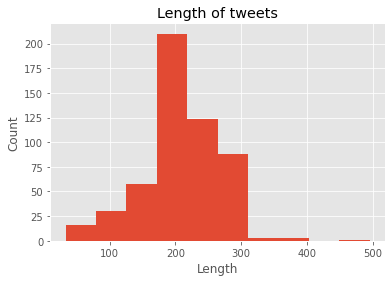

In [9]:
df_tweets_key['full_text'].str.len().hist()
plt.title(label='Length of tweets')
plt.xlabel('Length')
plt.ylabel('Count')

Each of the tweets is associated with a keyword that represents each of the categories where it is expected to analyze citizen perception regarding the needs of the city. Next figure shows the number of tweets classified in each of them, “rural” and “movilidad” seem to be the topics where there is more interaction, while “clean energies” and “animal welfare” categories seem to be those with the least interaction. 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


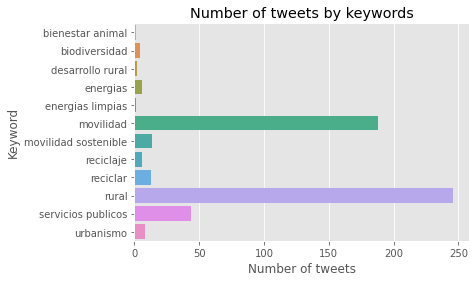

In [10]:
# topic with the most interest by the people
df_words_count = df_tweets_key.groupby('key_word')['id_key_word'].count().to_frame().reset_index()
df_words_count.columns = ['key_word','number_of_tweets']
# bar plot 
sns.barplot(df_words_count['number_of_tweets'],df_words_count['key_word'])
plt.title(label='Number of tweets by keywords')
plt.xlabel('Number of tweets')
plt.ylabel('Keyword')
plt.show()

By exploring the text of the tweets in each of the categories, a first impression of the topics related to each of them was obtained. In this way it is possible to establish a first approximation of the text content with positive or negative perceptions. The use of a word cloud for each of the categories can be useful for this purpose since it results in a visualization where the most frequently occurring words stand out more in the graph.

In [11]:
# get a dataFrame for every of the most referenced topics
df_movilidad = df_tweets_key[df_tweets_key['key_word'] == 'movilidad'].reset_index(drop=True)
df_rural = df_tweets_key[df_tweets_key['key_word'] == 'rural'].reset_index(drop=True)
df_servicios_publicos = df_tweets_key[df_tweets_key['key_word'] == 'servicios publicos'].reset_index(drop=True)

We will use two functions to deploy the word clouds. The first one will prepare the data frame to be use in a word cloud and the Second one will plot the word cloud.We will execute this function only for the peoples three preferred topics.

In [12]:
# delete stop words in every tweet
from nltk.corpus import stopwords
# define stop words
stopwords = stopwords.words("spanish")
aditional_stop_words = [',','.','#','@','-','%']
for stop_word in aditional_stop_words:
  stopwords.append(stop_word)

def create_wc_columns(df):
  '''
  recieve one dataFrame and return de same dataFrame with two new columns, one with the stop words 
  from the tweet and one with the words to be shown on the word cloud
  '''

  df['word_cloud'] = ''
  df['stop_words'] = ''

  for row in range(len(df['full_text'])):
    words = nltk.word_tokenize(df['full_text'][row])
    for word in words:
      word = word.lower()
      word = word.replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u").replace("-","")
      if word in stopwords:
        df['stop_words'][row] = df['stop_words'][row] +' '+word
      else:
        if len(str(df['word_cloud'][row])) == 0:
          df['word_cloud'][row] = word
        else:
          df['word_cloud'][row] = df['word_cloud'][row] + ' ' + word

        # print(word)
  
  return df

In [13]:
## Setting the resolution for better clarity 
from pylab import rcParams
rcParams['figure.figsize'] = 30, 60

def word_cloud_rating(df):
    word_cloud_text = ''.join(df.word_cloud)
    wordcloud = WordCloud(max_font_size=100, max_words=30,\
                          scale = 10,width=800, height=400).generate(word_cloud_text)


    # Plotting the generated word cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

From the rural category in the next word cloud, words such as “webstories” and “comunas” have a high frequency. However after a brief investigation concerning these particular words it was found that these are just labels included in the official communications of the Mayor’s office of Medellín. An interesting aspect of this analysis was the presence of words such as “violencia” or “fortalecimiento”, because the first one could be associated with a negative perception whereas the second one with a positive perception. 

/var/folders/df/rgn2104s10v9n3b8vz9xbq1r0000gn/T/ipykernel_7930/3364938426.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stop_words'][row] = df['stop_words'][row] +' '+word
/var/folders/df/rgn2104s10v9n3b8vz9xbq1r0000gn/T/ipykernel_7930/3364938426.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_cloud'][row] = word
/var/folders/df/rgn2104s10v9n3b8vz9xbq1r0000gn/T/ipykernel_7930/3364938426.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

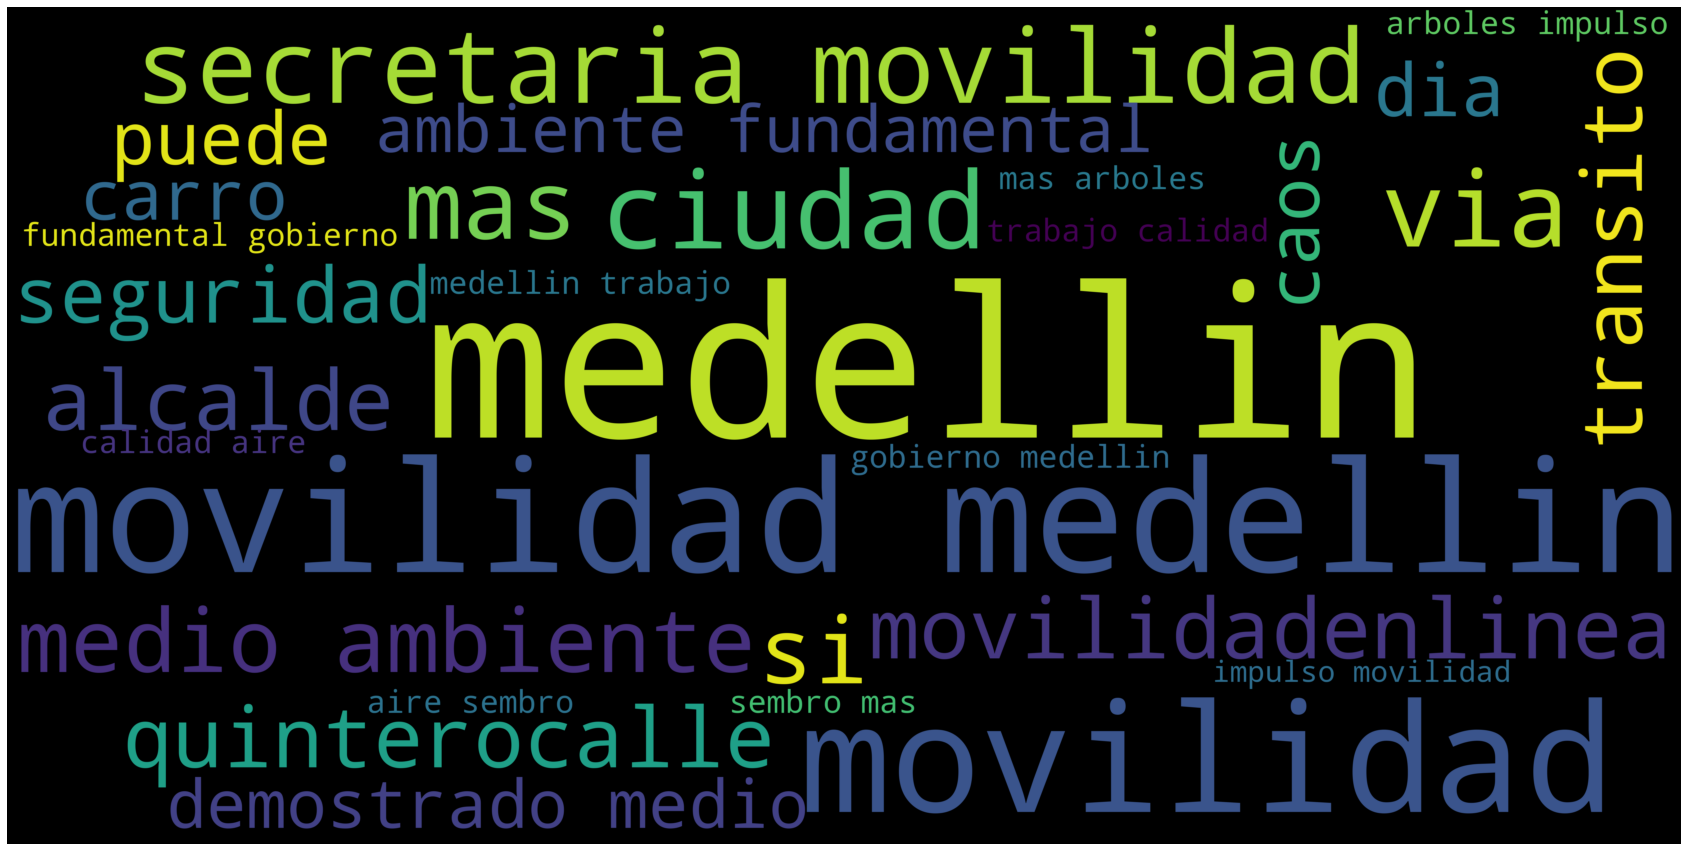

In [14]:
df_movilidad_wc = create_wc_columns(df_movilidad)
word_cloud_rating(df_movilidad_wc)

Regarding the word cloud for the “movilidad” keyword, it is possible to make a couple of observations. There are words that could incorporate an implicit perception or sentiment. An example of this fact could be the “caos” word because this one could be relationed with a negative sentiment. The higher frequency words might be included in other special categories in order to make a future and particular analysis. Another example of this approach would be the word “seguridad” since its connotation is unrelated to a sentiment directly. 

/var/folders/df/rgn2104s10v9n3b8vz9xbq1r0000gn/T/ipykernel_7930/3364938426.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_cloud'][row] = word
/var/folders/df/rgn2104s10v9n3b8vz9xbq1r0000gn/T/ipykernel_7930/3364938426.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_cloud'][row] = df['word_cloud'][row] + ' ' + word
/var/folders/df/rgn2104s10v9n3b8vz9xbq1r0000gn/T/ipykernel_7930/3364938426.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

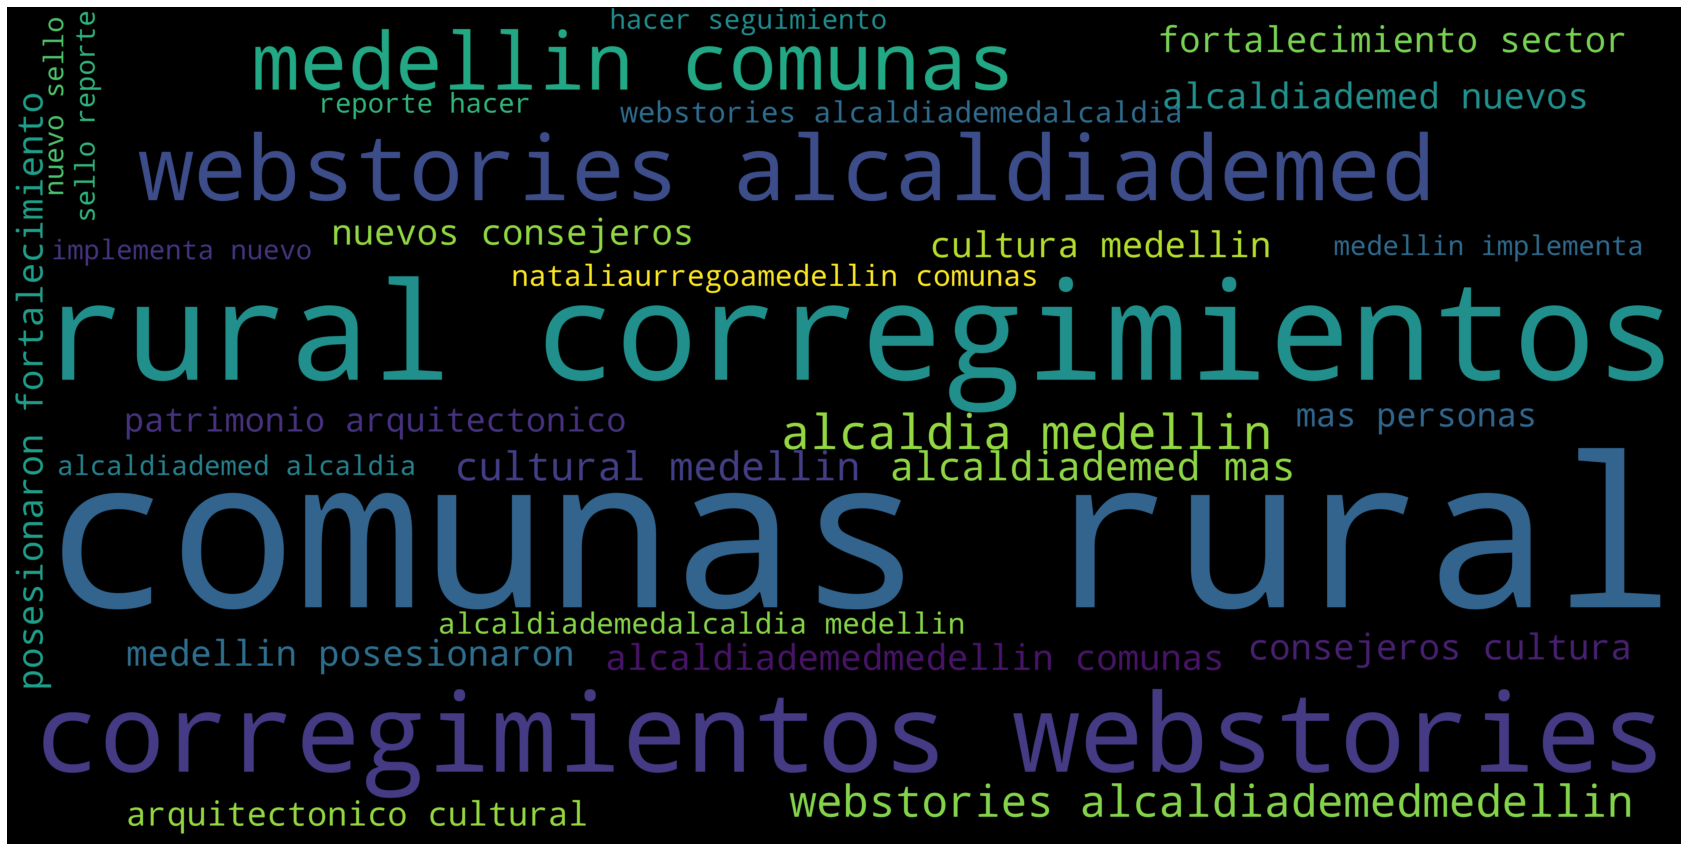

In [15]:
df_rural_wc = create_wc_columns(df_rural)
word_cloud_rating(df_rural_wc)

As for the category of ‘servicios públicos’, words such as 'insecurity', 'garbage' or 'more expensive' may be associated with negative feelings.

/var/folders/df/rgn2104s10v9n3b8vz9xbq1r0000gn/T/ipykernel_7930/3364938426.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stop_words'][row] = df['stop_words'][row] +' '+word
/var/folders/df/rgn2104s10v9n3b8vz9xbq1r0000gn/T/ipykernel_7930/3364938426.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_cloud'][row] = word
/var/folders/df/rgn2104s10v9n3b8vz9xbq1r0000gn/T/ipykernel_7930/3364938426.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

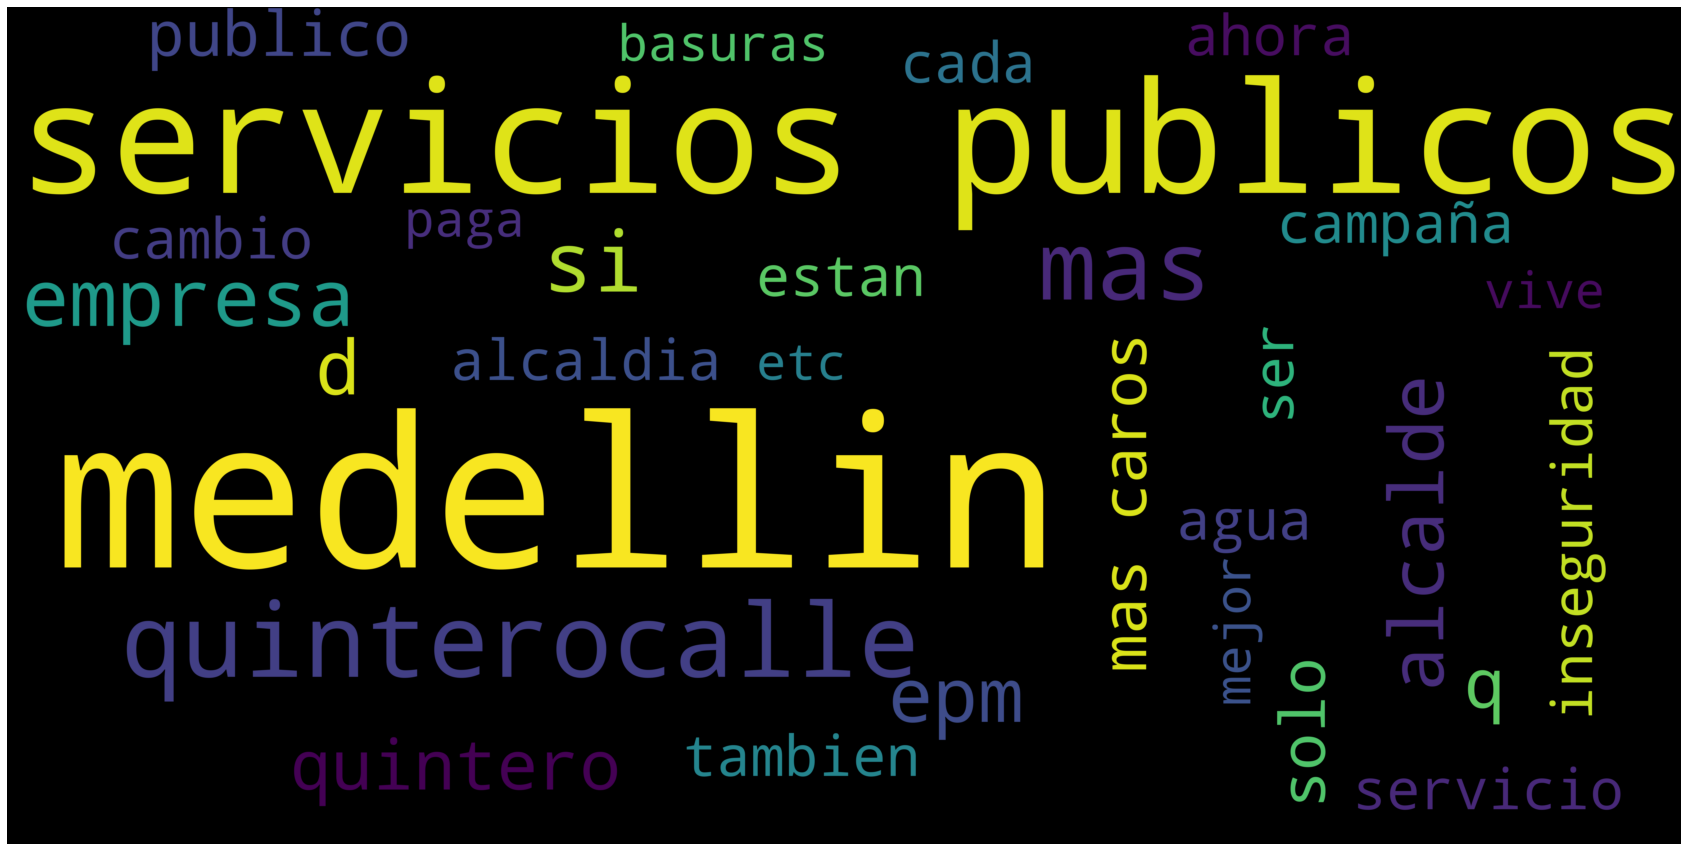

In [16]:
df_servicios_publicos_wc = create_wc_columns(df_servicios_publicos)
word_cloud_rating(df_servicios_publicos_wc)

Additionally, in the process of understanding the frequency of participation of citizens on Twitter regarding the same categories previously indicated, it is noticeable that the days with the highest record are during the weekdays, between Tuesday and Thursday. On the other hand, from Friday to Monday are the days of less interaction. This can be understood since weekends represent days of social leisure activities, and less digital activity.

Text(0, 0.5, 'Tweets')

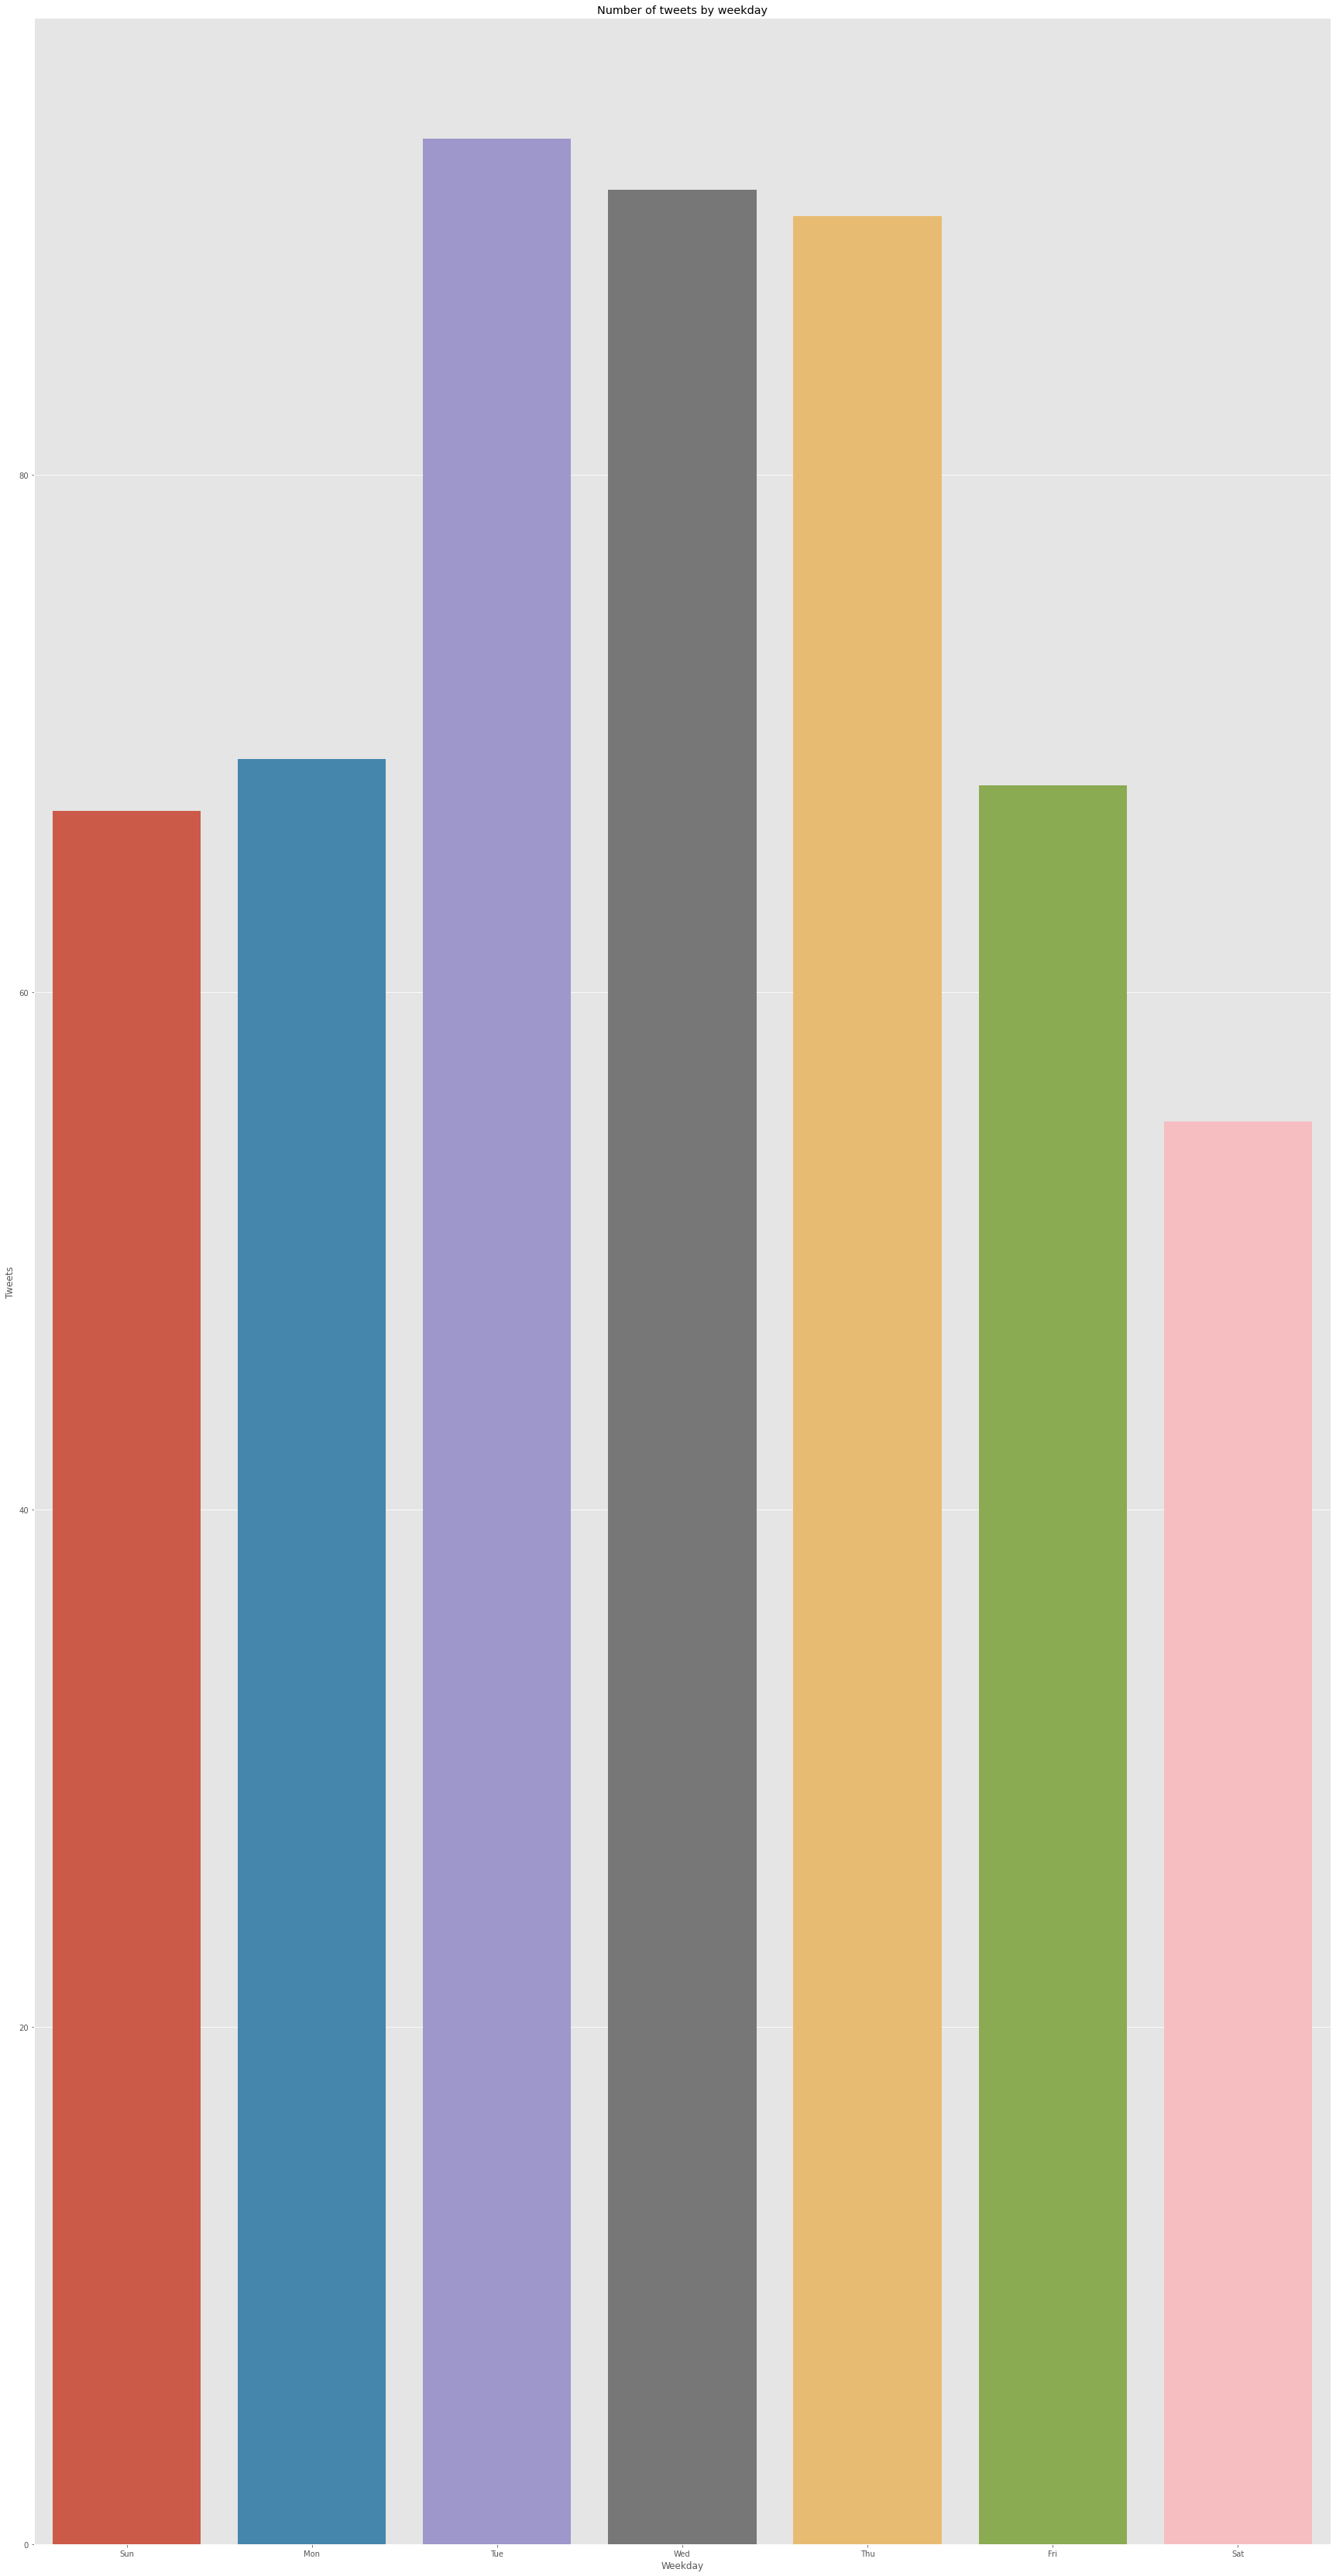

In [17]:
# amount of tweets by day of the week
df_tweets_key['date_modified']=pd.to_datetime(df_tweets_key['date']).dt.weekday
new_df=df_tweets_key.groupby(['date_modified'])['date_modified'].count().to_frame().rename(columns={'date_modified':'count'}).reset_index()
week=['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
new_df['date_modified']=week
sns.barplot(data=new_df,x='date_modified',y='count')
plt.title(label='Number of tweets by weekday')
plt.xlabel('Weekday')
plt.ylabel('Tweets')

Analyzing in more detail the frequency of participation of the same users as shown in the next plot, we find that the hours of the day in which most interaction occurs are at 1pm, 6pm, 7pm and 11 pm. It is easy to infer that these time slots are very likely related to lunchtime, the time after leaving work activities and just before going to sleep, respectively. Interestingly, being bedtime at midnight there is a relatively high activity, specifically at 1 am.


Text(0, 0.5, 'Tweets')

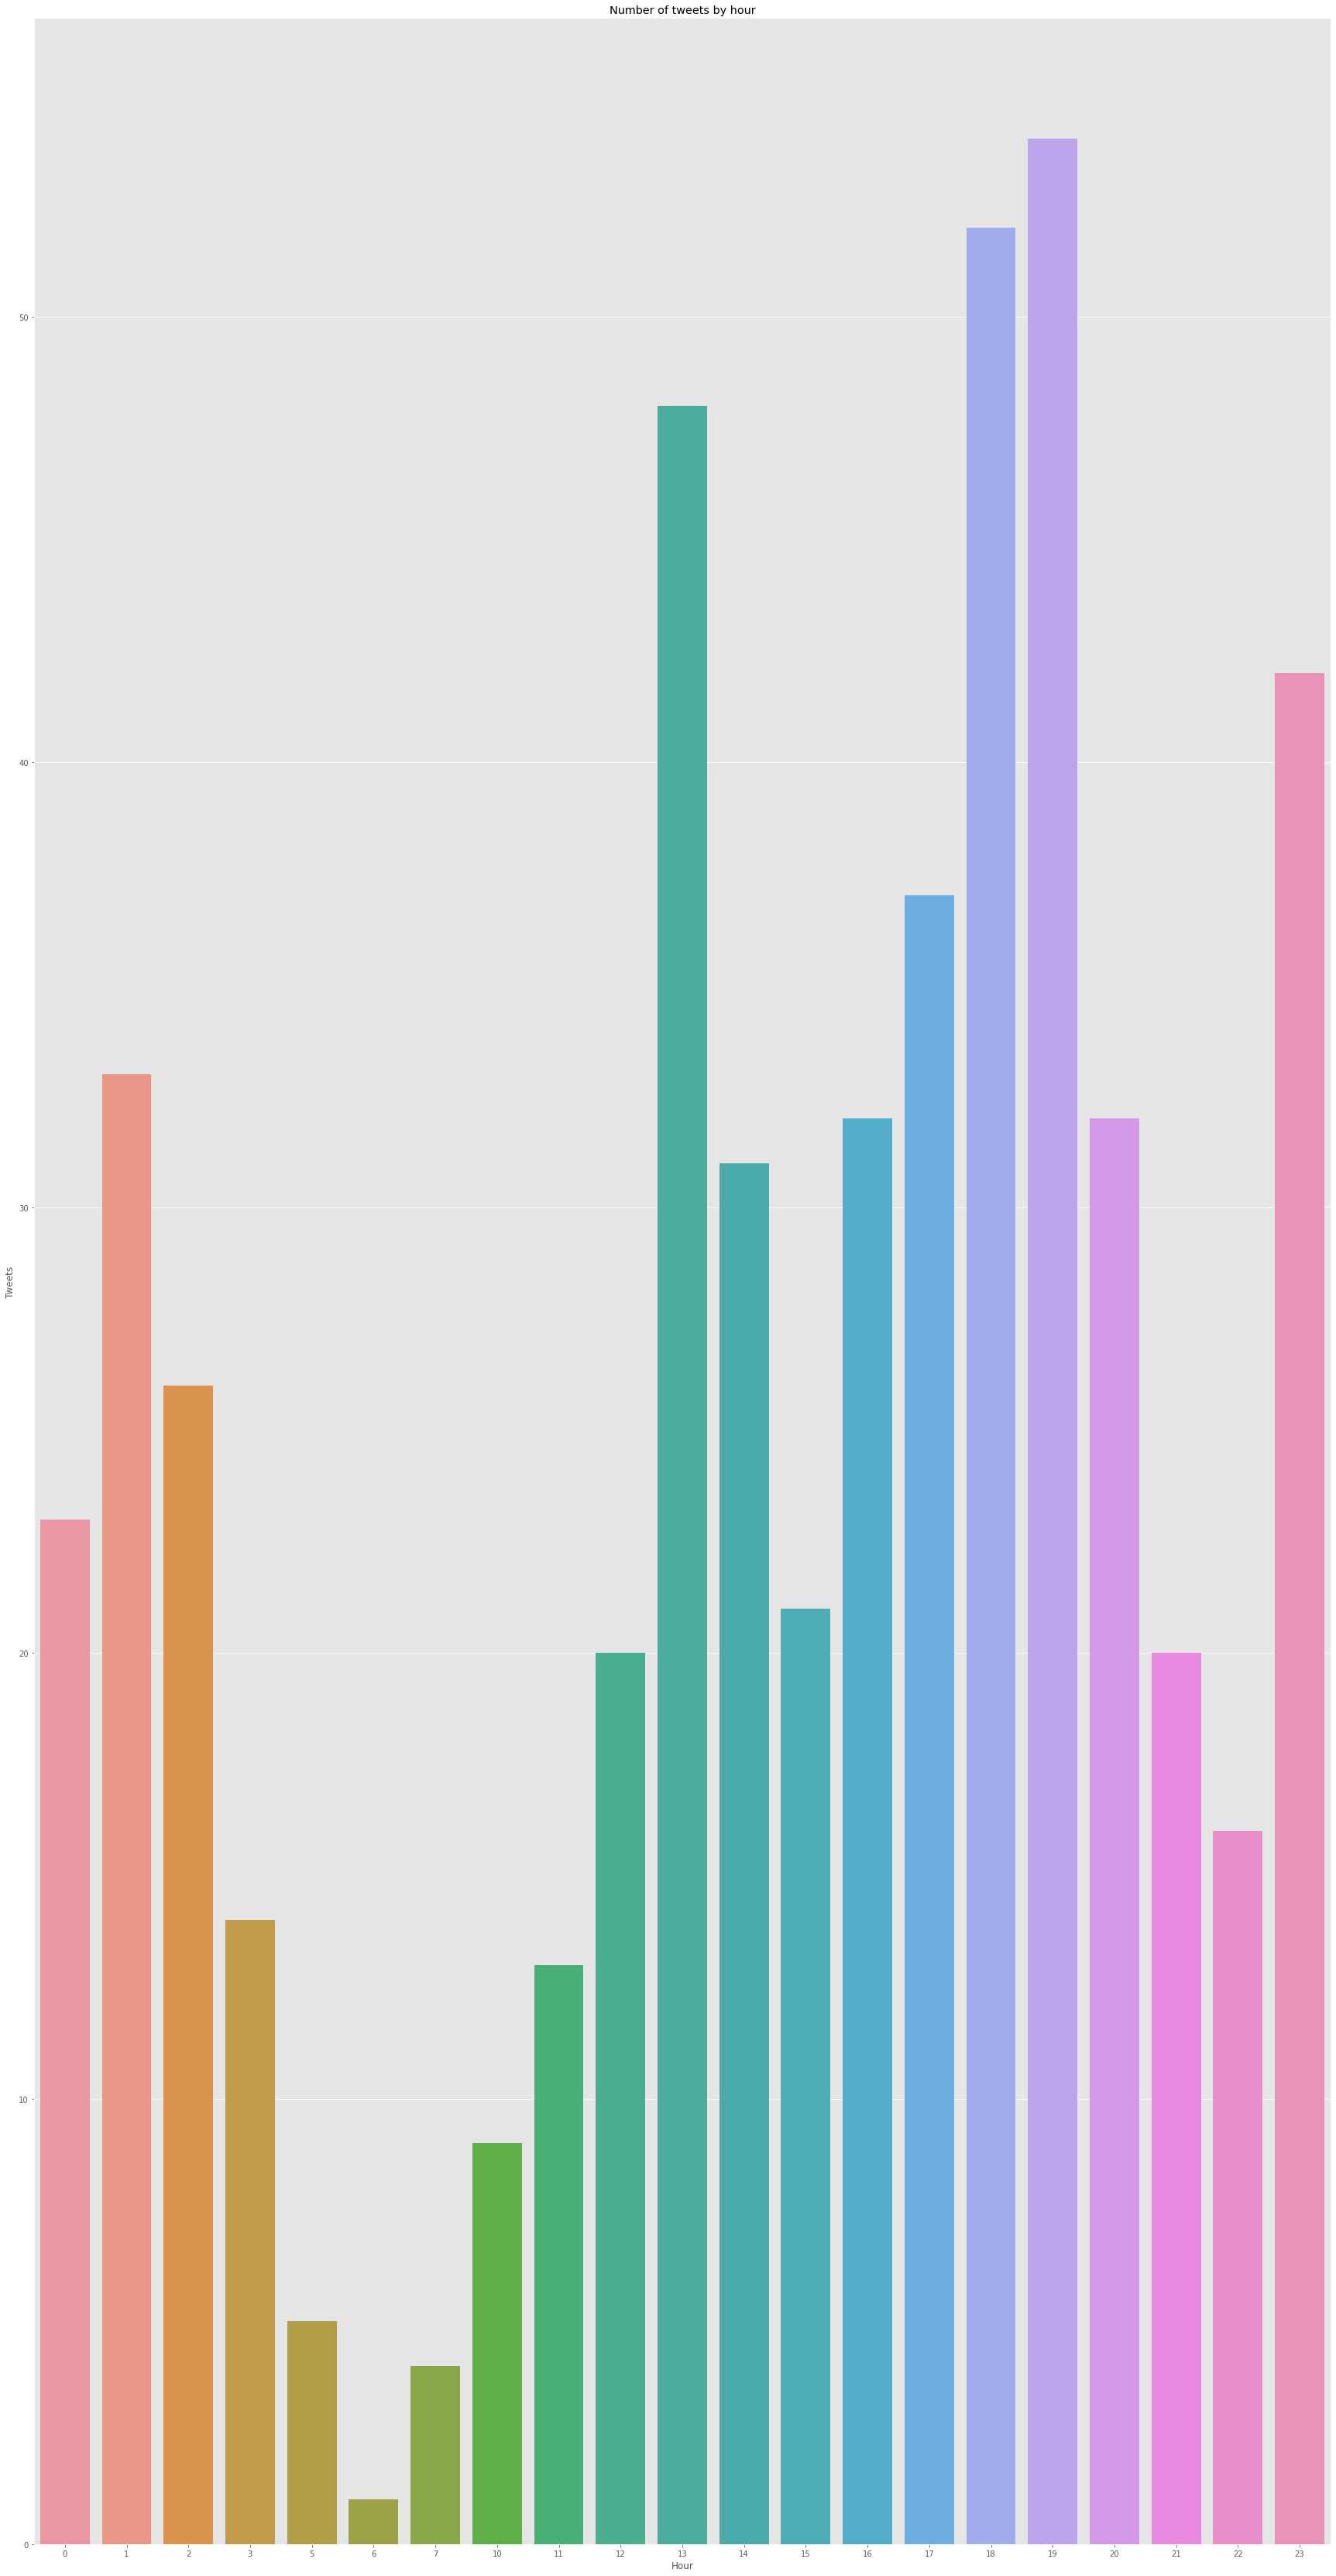

In [18]:
# amount of tweets by hour
df_tweets_key['date_modified']=pd.to_datetime(df_tweets_key['date']).dt.hour
sns.countplot(data=df_tweets_key,x='date_modified')
plt.title(label='Number of tweets by hour')
plt.xlabel('Hour')
plt.ylabel('Tweets')

The number of retweets and likes will show the relevance of the topic for the users, according to the graphic the people are more interested in the rural topic showing a big interest in the events outside the city, in those zones are more difficulties to access internet so the people who are tweeting are probably the ones who lives in the city. Mobility is the second topic among the twitter users, this must be a recurrent problem inside the city and something that hits everybody every day which could explain why people are usually talking about it. 

Text(0, 0.5, 'Retweets')

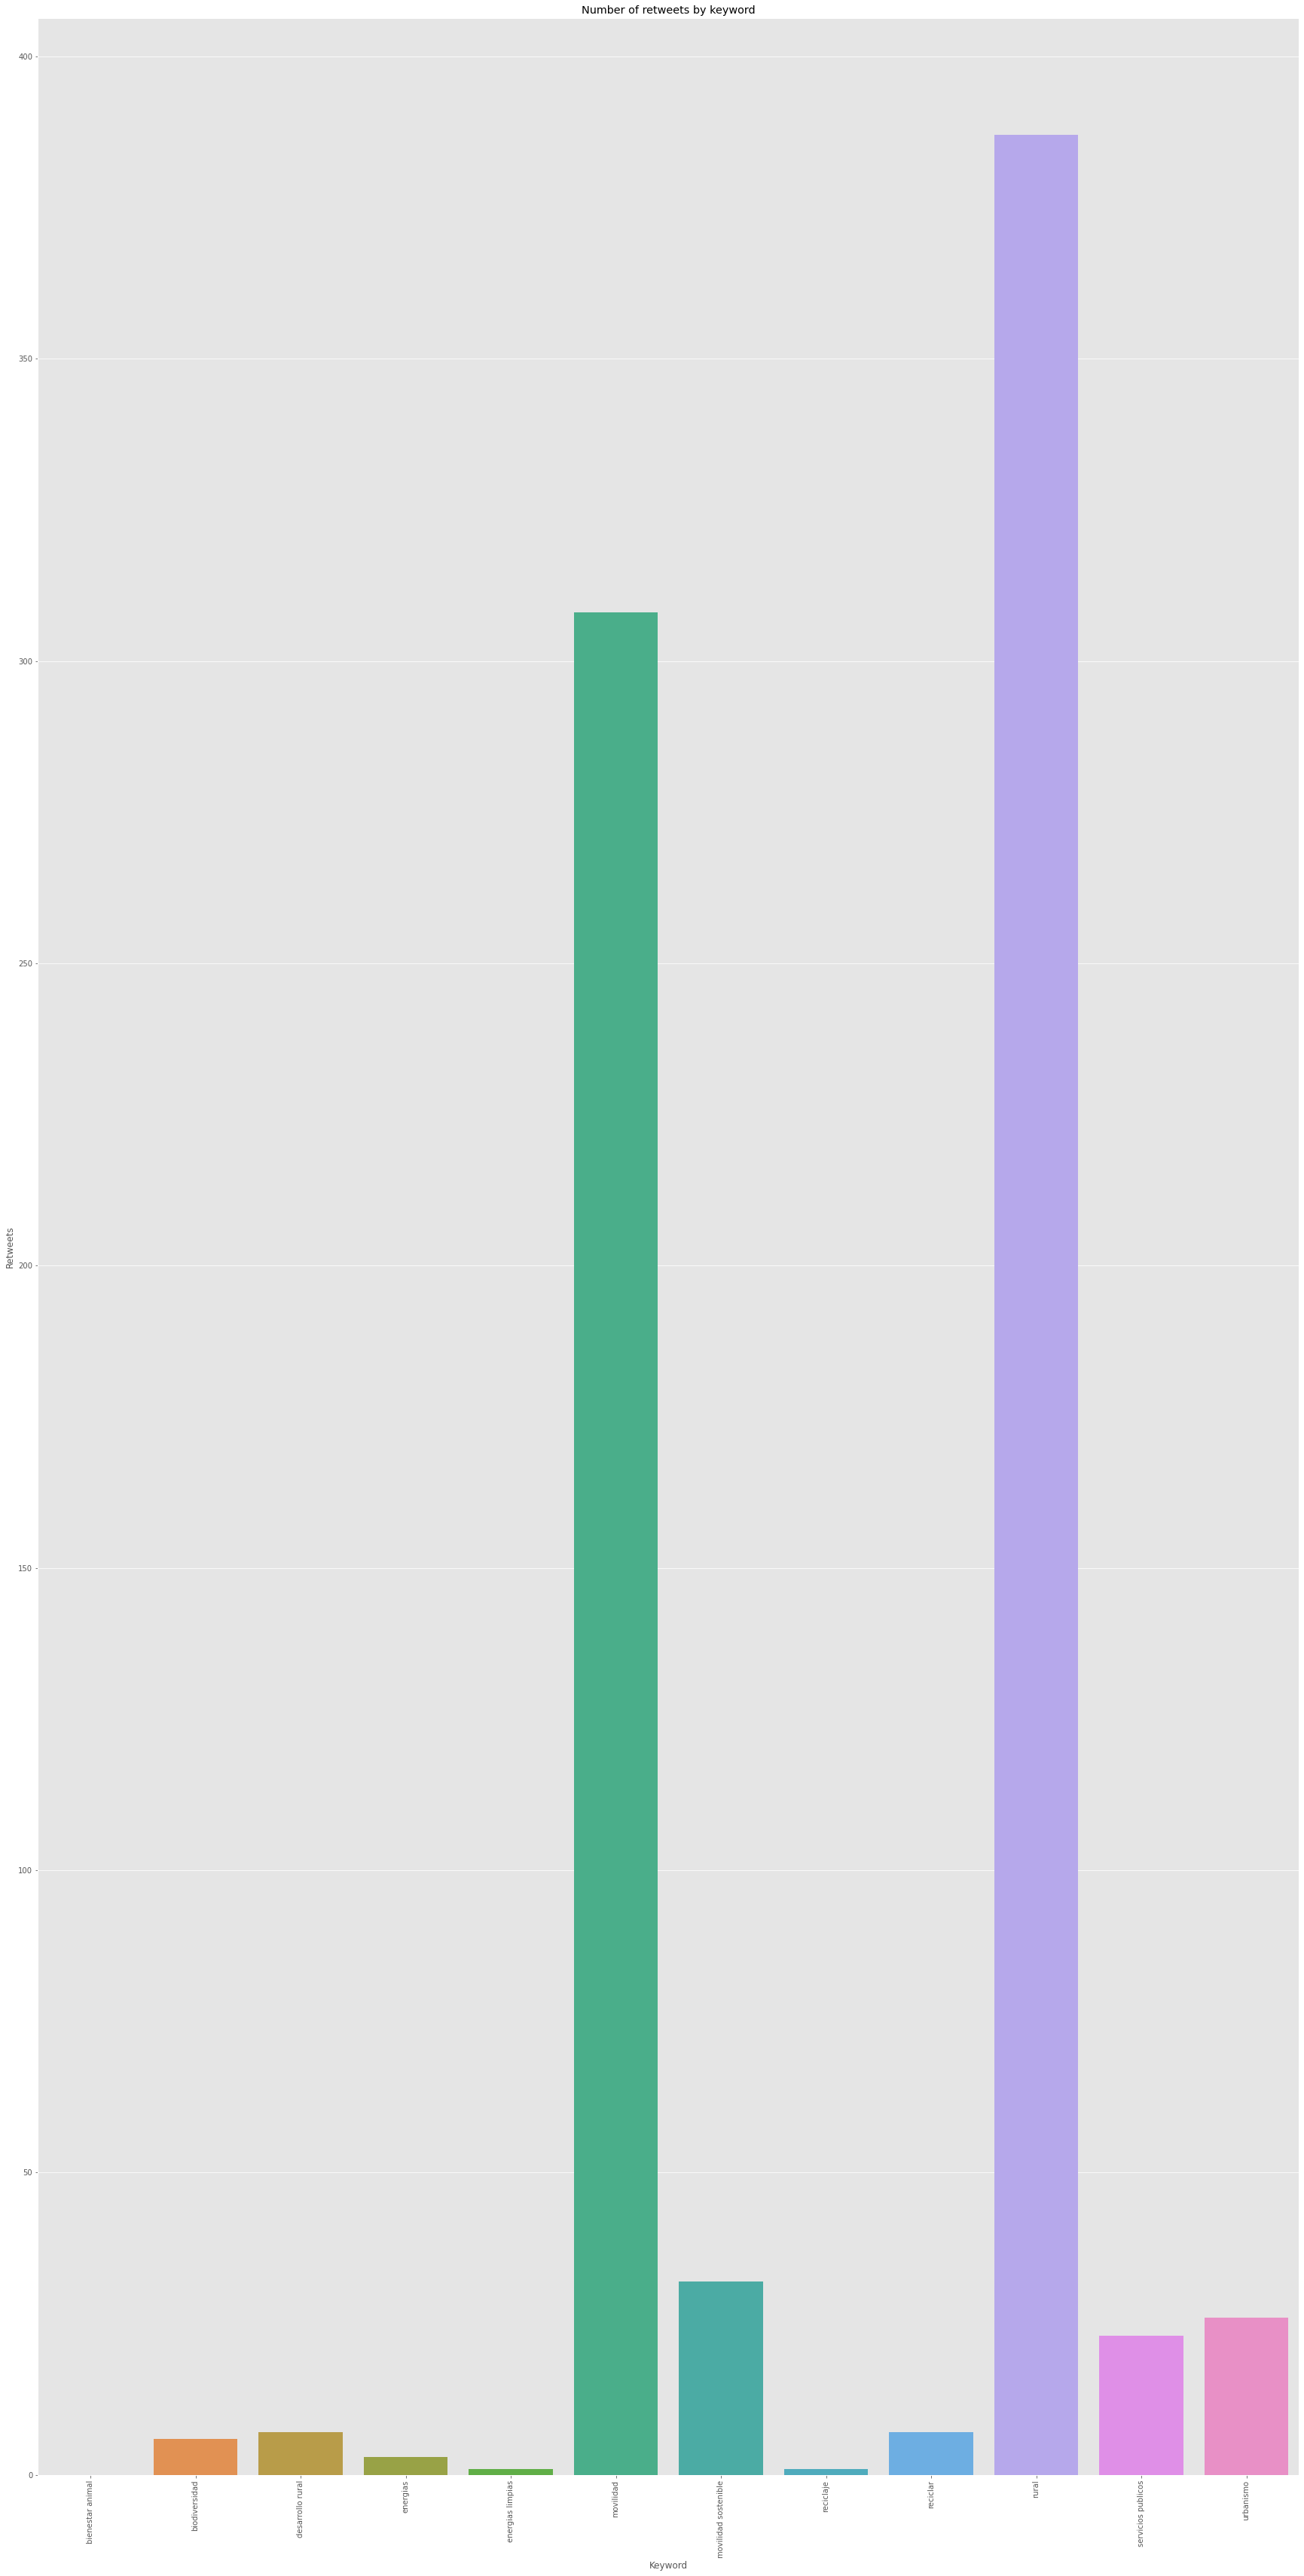

In [19]:
# number of retwwets by keyword
df_rt_by_key_word = df_tweets_key.groupby('key_word')['number_rt'].sum().to_frame()
sns.barplot(x=df_rt_by_key_word.index, y=df_rt_by_key_word['number_rt'])
plt.xticks(rotation = 90)
plt.title(label='Number of retweets by keyword')
plt.xlabel('Keyword')
plt.ylabel('Retweets')

Text(0, 0.5, 'Likes')

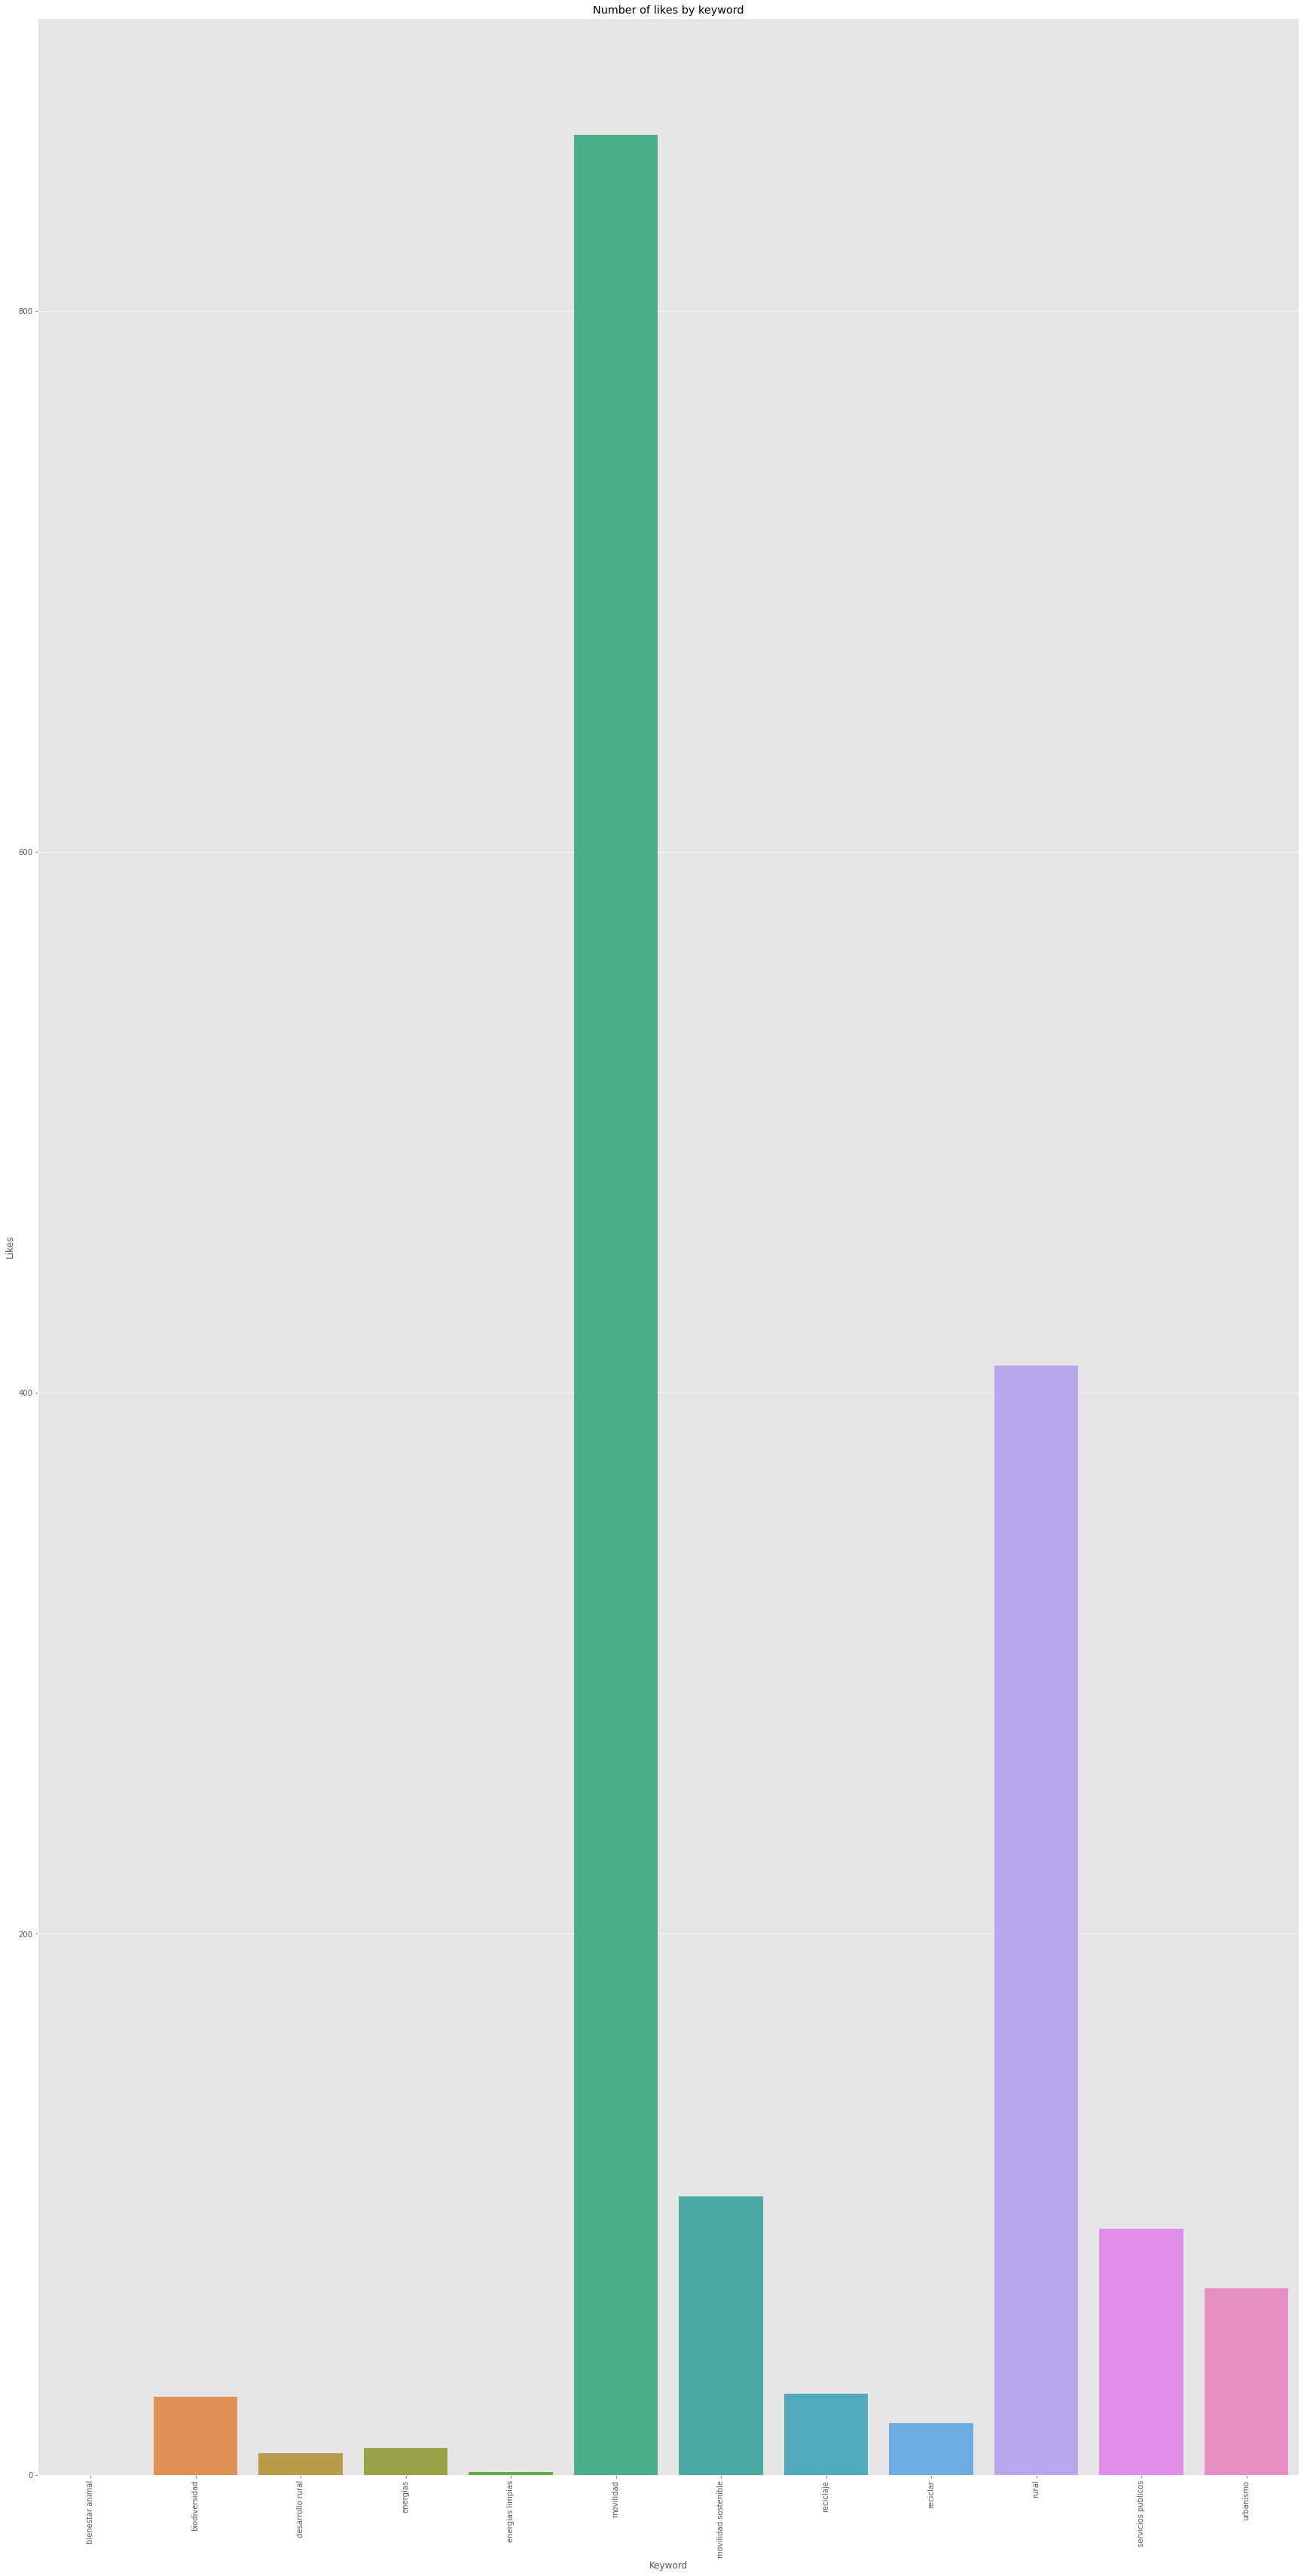

In [20]:
# number of likes by keyword
df_likes_by_key_word = df_tweets_key.groupby('key_word')['number_likes'].sum().to_frame()
sns.barplot(x=df_likes_by_key_word.index, y=df_likes_by_key_word['number_likes'])
plt.xticks(rotation = 90)
plt.title(label='Number of likes by keyword')
plt.xlabel('Keyword')
plt.ylabel('Likes')

The word cloud of all tweets supports the conclusion of the second plot, where the categories “rural” and “movilidad” are the most interactive. Figure 10 again shows a high frequency of words such as “rural”, comunas”, “corregimientos”, where it is possible to suppose that citizen needs are not just for urban areas. Furthermore, words such as “webstories” or “Alcaldia de Medellín” reflect a high interaction of local government regarding city opinions.  

/var/folders/df/rgn2104s10v9n3b8vz9xbq1r0000gn/T/ipykernel_7930/3364938426.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_cloud'][row] = word
/var/folders/df/rgn2104s10v9n3b8vz9xbq1r0000gn/T/ipykernel_7930/3364938426.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_cloud'][row] = df['word_cloud'][row] + ' ' + word
/var/folders/df/rgn2104s10v9n3b8vz9xbq1r0000gn/T/ipykernel_7930/3364938426.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

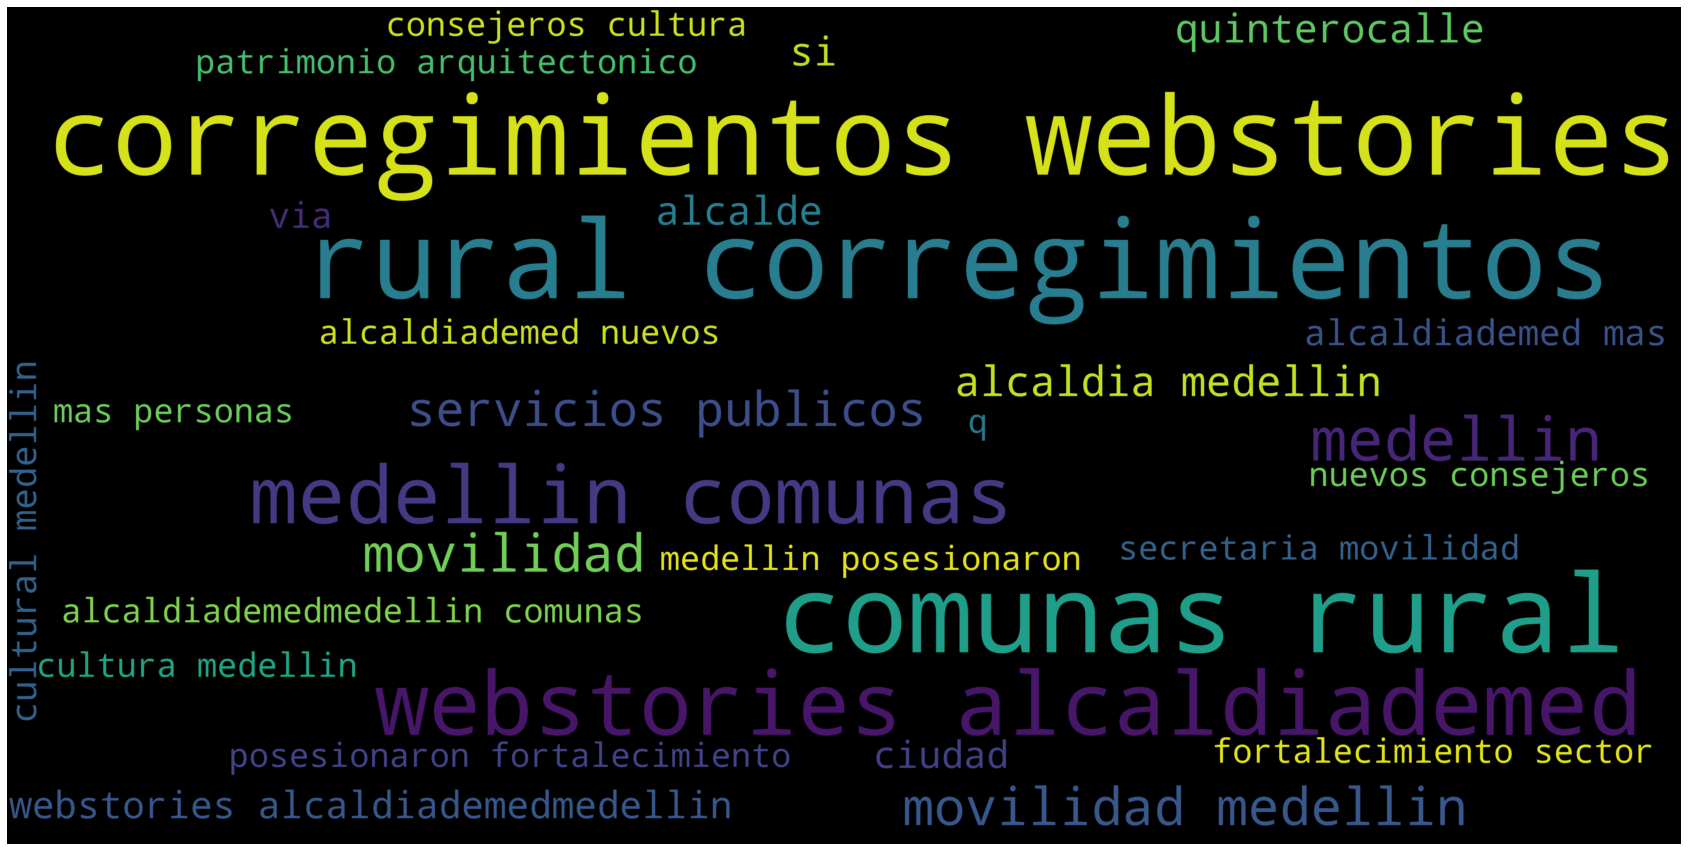

In [21]:
# word cloud for all the tweets
df_tweets_key_wc = create_wc_columns(df_tweets_key)
word_cloud_rating(df_tweets_key_wc)

The final word cloud represents the location associated with each of the tweets extracted, as expected, 'Colombia-Medellín”, “Colombia-Antioquia” and “Antioquia” are words that strengthen the idea that the citizens of this region are who most generate information related to the needs of their territory. That other locations appear in the word cloud are also not surprising because any resident outside of Medellin can also generate opinions about the city.


/var/folders/df/rgn2104s10v9n3b8vz9xbq1r0000gn/T/ipykernel_7930/3364938426.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_cloud'][row] = word
/var/folders/df/rgn2104s10v9n3b8vz9xbq1r0000gn/T/ipykernel_7930/3364938426.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_cloud'][row] = df['word_cloud'][row] + ' ' + word
/var/folders/df/rgn2104s10v9n3b8vz9xbq1r0000gn/T/ipykernel_7930/3364938426.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

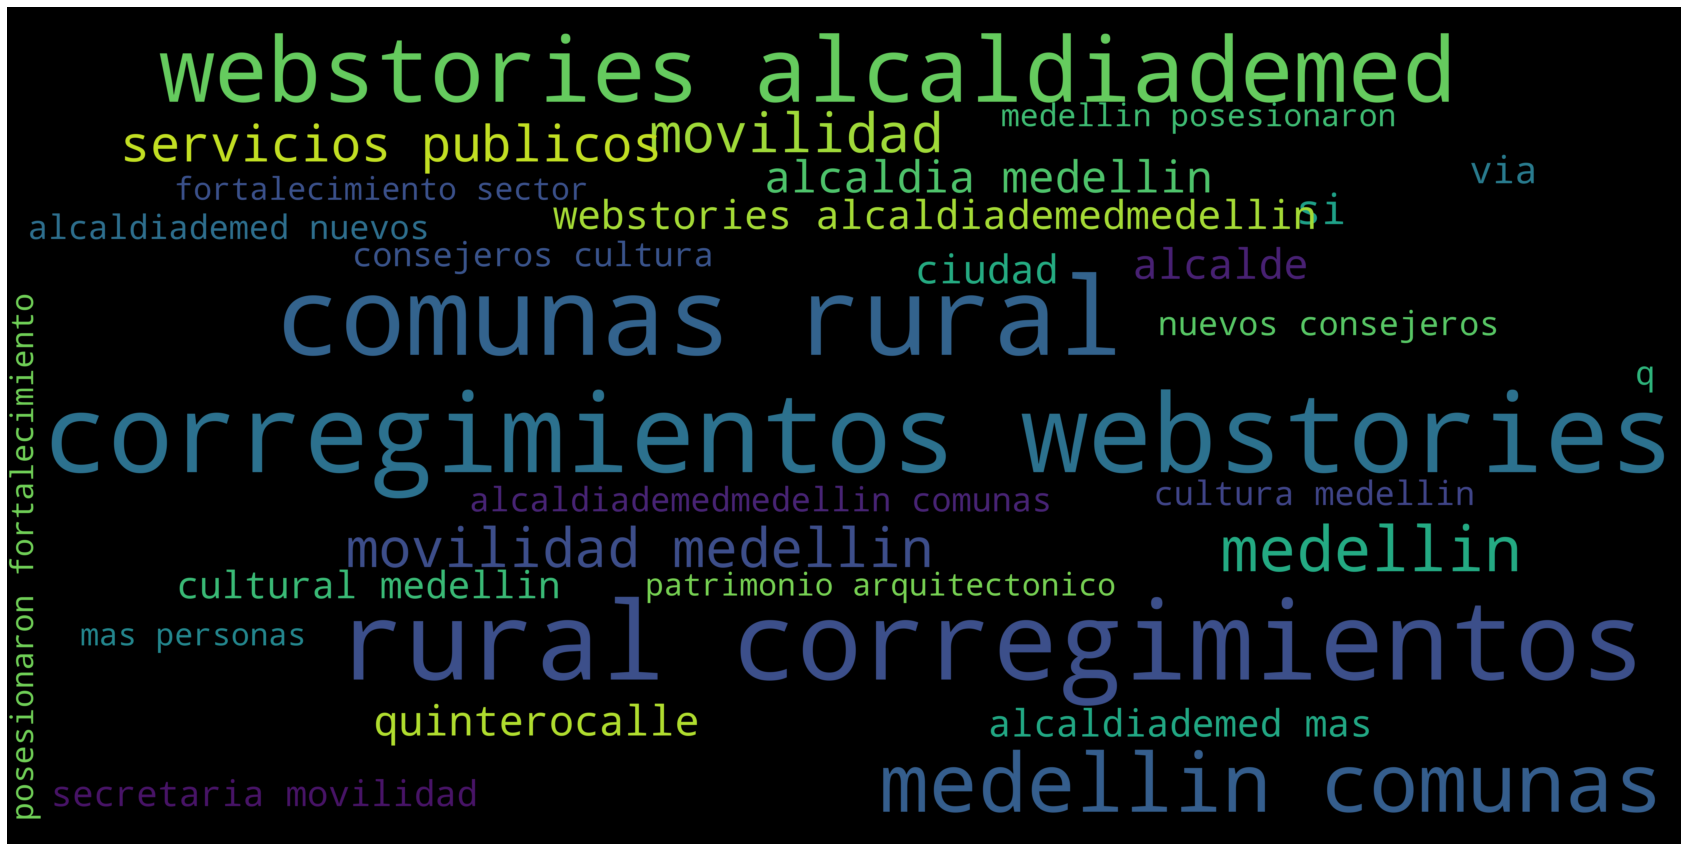

In [22]:
# word cloud for all the tweets
df_tweets_key_wc = create_wc_columns(df_tweets_key)
word_cloud_rating(df_tweets_key_wc)